In [1]:
import os, sys, h5py
import numpy as np
import itertools
from six.moves import cPickle
from scipy import stats

import helper
import global_importance
from tensorflow import keras
from keras import backend as K

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:

rbp_index = 69
model_name = 'residualbind'
normalize_method = 'clip_norm'   # 'log_norm' or 'clip_norm'
ss_type = 'seq'                  # 'seq', 'pu', or 'struct'
results_path = helper.make_directory('..','results')
save_path = helper.make_directory(results_path, model_name+'_'+normalize_method+'_'+ss_type)


data_path = '../data/RNAcompete_2013/rnacompete2013.h5'
train, valid, test = helper.load_dataset_hdf5(data_path, ss_type='seq', rbp_index=rbp_index)

experiments = helper.get_experiments_hdf5(data_path)
experiment = experiments[rbp_index].decode('UTF-8')
print(experiment)

RNCMPT00168


In [3]:
K.clear_session()
    
# load model
inputs, outputs = helper.load_model(model_name)
model = keras.Model(inputs=inputs, outputs=outputs)

# set up optimizer and metrics
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

# set to best model
weights_path = os.path.join(save_path, experiment + '_weights.hdf5')
model.load_weights(weights_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [4]:
import global_importance as gi
alphabet = 'ACGU'

profile = np.mean(np.squeeze(train['inputs']), axis=0)
profile /= np.sum(profile, axis=1, keepdims=True)


null_sequence = gi.sample_profile_sequences(profile, num_sim=1000)


In [72]:
experiment

'RNCMPT00168'

In [62]:
kmer_size = 6
position = 17
kmers, mean_scores = gi.optimal_kmer(model, null_sequence, kmer_size, position, alphabet)


500 out of 4096
1000 out of 4096
1500 out of 4096
2000 out of 4096
2500 out of 4096
3000 out of 4096
3500 out of 4096
4000 out of 4096


In [63]:
for i in range(10):
    print(kmers[i], mean_scores[i])

UGCAUG 4.5963407
AGCAUG 4.4789753
GCAUGA 4.3673005
GCAUGC 4.2471924
GCAUGU 3.8702142
GCAUGG 3.7201858
CGCAUG 3.7197943
GGCAUG 2.7172503
UGCACG 2.5834138
GCACGA 1.888329


In [67]:
motif = kmers[0]
position = 17
mean_scores = gi.mutagenesis(model, null_sequence, motif, position, alphabet)

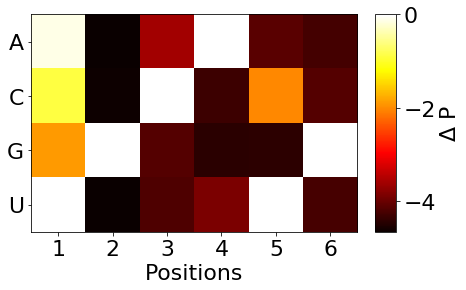

In [71]:
fig = plt.figure()
ax = plt.axes()
im = ax.imshow(mean_scores.T - np.max(mean_scores), cmap='hot')
plt.xlabel('Positions', fontsize=22)
plt.xticks(range(len(motif)), range(1,len(motif)+1), fontsize=22, ha='center');
plt.yticks([0,1,2,3], ['A', 'C', 'G', 'U'], fontsize=22)

cax = fig.add_axes([ax.get_position().x1+0.04, ax.get_position().y0, 0.05, ax.get_position().height])
cbar = plt.colorbar(im, cax=cax, fraction=95, pad=0.1) 
cbar.ax.tick_params(labelsize=22) 

plt.ylabel('$\Delta$ P', fontsize=22);



In [7]:
motif='UGCAUG'
positions = [2, 8, 14, 20, 26, 32]
mean_scores, all_scores = gi.positional_bias(model, null_sequence, motif, positions, alphabet)

In [10]:
all_scores.shape

(7, 1000)

Text(0.5, 0, 'Positions')

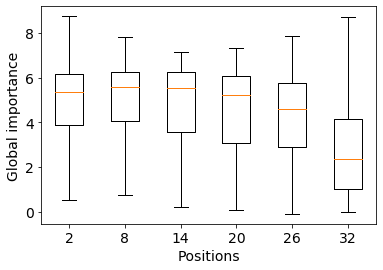

In [12]:
fig = plt.figure()
plt.boxplot(all_scores[1:,:].T, showfliers=False);
plt.xticks(range(1,len(positions)+1), positions, fontsize=14, ha='center');
ax = plt.gca();
plt.setp(ax.get_yticklabels(),fontsize=14);
plt.ylabel('Global importance', fontsize=14)
plt.xlabel('Positions', fontsize=14)
#outfile = os.path.join(save_path, experiment+'_motif_location_syn_norm.pdf')
#fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

In [20]:
motif = 'UGCAUG'
positions = [23, 2, 12, 30]

mean_scores, all_scores = gi.multiple_sites(model, null_sequence, motif, positions, alphabet)

Text(0, 0.5, 'Global importance')

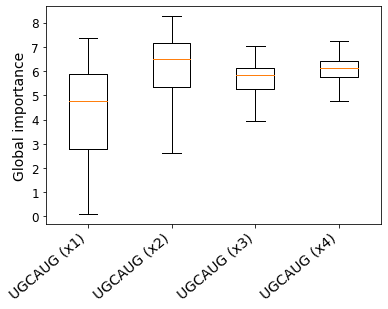

In [21]:

fig = plt.figure()
plt.boxplot(all_scores[1:,:].T, showfliers=False);
plt.xticks(range(1,len(positions)+1), [motif+' (x1)', motif+' (x2)', motif+' (x3)', motif+' (x4)'], rotation=40, fontsize=14, ha='right');
ax = plt.gca();
plt.setp(ax.get_yticklabels(),fontsize=12)
plt.ylabel('Global importance', fontsize=14);
#outfile = os.path.join(save_path, experiment+'_multiple_sites_exp.pdf')
#fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')


In [5]:
motif='UGCAUG'
motif_position=17
gc_motif='GCGCGC'
gc_positions=[34, 2]

mean_scoress, all_scores = gi.gc_bias(model, null_sequence, motif, motif_position,
                                      gc_motif, gc_positions, alphabet)

In [77]:

fig = plt.figure()
plt.boxplot(all_scores[:,:].T, showfliers=False);
plt.xticks([1, 2, 3, 4, 5, 6], ['Random', 'GC (right)', 'Motif', 'Motif+GC (right)', 'Motif+GC (left)'], rotation=40, fontsize=14, ha='right');
ax = plt.gca();
plt.setp(ax.get_yticklabels(),fontsize=14);
plt.ylabel('Global importance', fontsize=14)
#outfile = os.path.join(save_path, experiment+'_gcbias_degeneracy.pdf')
#fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')


8.261183

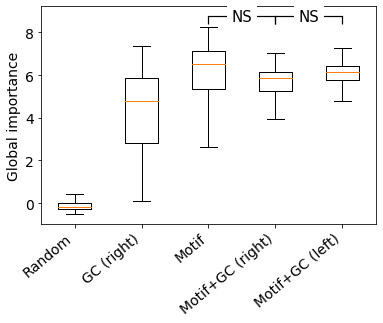

In [83]:

fig = plt.figure()
plt.boxplot(all_scores[:,:].T, showfliers=False);
plt.xticks([1, 2, 3, 4, 5, 6], ['Random', 'GC (right)', 'Motif', 'Motif+GC (right)', 'Motif+GC (left)'], rotation=40, fontsize=14, ha='right');
ax = plt.gca();
plt.setp(ax.get_yticklabels(),fontsize=14);
plt.ylabel('Global importance', fontsize=14)
#outfile = os.path.join(save_path, experiment+'_gcbias_degeneracy.pdf')
#fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')

start = 4
end = 5
height = np.max(all_scores)+.5
results = stats.ttest_ind(all_scores[:,start], all_scores[:,end])
if results.pvalue > 0.05:
    displaystring = 'NS'
else:
    displaystring = '*'
significance_bar(start,end,height,displaystring,linewidth=1.2,markersize=8,boxpad=0.3,fontsize=15,color='k')

start = 3
end = 4
height = np.max(all_scores)+.5
results = stats.ttest_ind(all_scores[:,start], all_scores[:,end])
if results.pvalue > 0.05:
    displaystring = 'NS'
else:
    displaystring = '*'
significance_bar(start,end,height,displaystring,linewidth=1.2,markersize=8,boxpad=0.3,fontsize=15,color='k')

